In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import gym
from main.maml_agent import MAMLAgent, register_flags
register_flags()
from main.alpaca import *
from main.dataset import *
from main.dataViz import *
import yaml

from main.rover import *
from main.terrain import *

WARN: Cannot define MaxPoolGrad, likely already defined for this version of tensorflow: "Registering two gradient with name 'MaxPoolGrad'! (Previous registration was in register /home/somrita/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/registry.py:66)"


In [2]:
cfg_filename = 'configs/rocker-bogie-config.yml'
with open(cfg_filename,'r') as ymlfile:
    config = yaml.load(ymlfile)

/home/somrita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


### Set up rover geometry

In [3]:
alpha = np.deg2rad(110)
beta = np.deg2rad(90)

# Pick the angles at horizontal level motion
th1 = np.deg2rad(45)
th2 = np.deg2rad(60)

# Find all the arm lengths
l1 = 2.0
l2 = 1.0
rem_ht = l1*np.sin(th1) - l2 * np.cos(alpha + th1 - np.pi/2)
l3 = rem_ht/np.sin(th2)
l4 = rem_ht/np.cos(beta + th2 - np.pi/2)

wheel_rad_1 = 0.4
wheel_rad_2 = 0.4
wheel_rad_3 = 0.4

body_len = 2.0
body_wid = 0.2

rover = Rover(l1, l2, l3, l4, alpha, beta, gamma = th1, wheel_rad = wheel_rad_1, body_len = body_len, body_wid = body_wid)

### Set rover on flat terrain

In [4]:
rover.set_terrain(FlatTerrain())

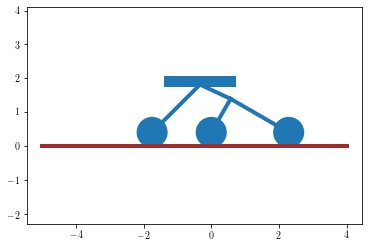

In [5]:
x2 = 0.0
r0, r1, rb, r2, r3 = rover.find_geom(x2)
ax = rover.plot_rover(r0, r1, rb, r2, r3)
plt.show()

### Set inertias

In [6]:
mass = 10.0 # kg
g = 9.81 # m/s2
rover.set_inertias(mass = mass, g = g)

# Dataset

In [7]:
dataset = RockerBogieDataset(config, rover)

## Default agent

In [8]:
g1 = tf.Graph()
sess1 = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=g1)
agent = ALPaCA(config, sess1, g1)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [9]:
agent.construct_model()






Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

x_dim  5
y_dim  2
phi_dim  16
phi shape  (?, ?, 16)
context phi shape  (?, ?, 16)
K shape  (?, 16, 2)











In [11]:
agent.train(dataset,500)

loss: 75.087494
K shape  (?, 16, 2)
loss: -3.6773493
K shape  (?, 16, 2)
loss: -7.749185
K shape  (?, 16, 2)
loss: -9.685824
K shape  (?, 16, 2)
loss: -10.251673
K shape  (?, 16, 2)
loss: -9.643659
K shape  (?, 16, 2)
loss: -10.382123
K shape  (?, 16, 2)
loss: -10.499164
K shape  (?, 16, 2)
loss: -7.0887494
K shape  (?, 16, 2)
loss: -10.198377
K shape  (?, 16, 2)


# Visualize all agents

In [16]:
N_test = 50
test_horz = 30
X_test, Y_test = dataset.sample(N_test, test_horz)

In [17]:
#compute MSE and time
import time
import tqdm

def gaussian_nll(y,mu,Sig):
    n = 1
    logdet = np.log(Sig) 
    nll = n*np.log(2*np.pi) + logdet + ((y-mu).T * (1/Sig) * (y-mu))
    return 0.5*nll

def MSE(y,mu):
    return (y-mu)**2

def get_stats(meas, N):
    mean = sum(meas)/N
    var = sum([(nl - mean)**2 for nl in meas])/(N-1)
    return mean, var

alpaca_nll_mean = []
alpaca_nll_var = []
alpaca_time_mean = []
alpaca_time_var = []
alpaca_mse_mean = []
alpaca_mse_var = []

lpaca_nll_mean = []
lpaca_nll_var = []
lpaca_time_mean = []
lpaca_time_var = []


for j in tqdm.tqdm(range(test_horz)):
    nll_list_alpaca = []
    nll_list_lpaca = []
    
    mse_list_alpaca = []

    time_list_alpaca = []
    time_list_lpaca = []
    
    for ind in range(N_test):
        X_update = X_test[ind:(ind+1),:j,:]
        Y_update = Y_test[ind:(ind+1),:j,:]
        x_pt = X_test[ind:(ind+1),(j):(j+1),:]
        y_pt = Y_test[ind:(ind+1),(j):(j+1),:]
    
        t1_alpaca = time.process_time()
        y, s = agent.test(X_update, Y_update, x_pt)
        t2_alpaca = time.process_time()
        
#         t1_lpaca = time.process_time()
#         y_lpaca,s_lpaca = agent_nometa.test(X_update, Y_update, x_pt)
#         t2_lpaca = time.process_time()  
            
        nll_list_alpaca.append(gaussian_nll(y_pt[0,0,0],y[0,0,0],s[0,0,0,0]))
#         nll_list_lpaca.append(gaussian_nll(y_pt[0,0,0],y_lpaca[0,0,0],s_lpaca[0,0,0,0]))
        
        time_list_alpaca.append(t2_alpaca - t1_alpaca)
#         time_list_lpaca.append(t2_lpaca - t1_lpaca)
        
        mse_list_alpaca.append(MSE(y_pt[0,0,0],y[0,0,0]))
        
    time_mean_alpaca, time_var_alpaca = get_stats(time_list_alpaca,N_test)
#     time_mean_lpaca, time_var_lpaca = get_stats(time_list_lpaca,N_test)
    
    mse_mean_alpaca, mse_var_alpaca = get_stats(mse_list_alpaca,N_test)
    
    nll_mean_alpaca, nll_var_alpaca = get_stats(nll_list_alpaca,N_test)
#     nll_mean_lpaca, nll_var_lpaca = get_stats(nll_list_lpaca,N_test)
    
    alpaca_time_mean.append(time_mean_alpaca)
    alpaca_time_var.append(time_var_alpaca)
    
#     lpaca_time_mean.append(time_mean_lpaca)
#     lpaca_time_var.append(time_var_lpaca)
    
    alpaca_mse_mean.append(mse_mean_alpaca)
    alpaca_mse_var.append(mse_var_alpaca)
    
    alpaca_nll_mean.append(nll_mean_alpaca)
    alpaca_nll_var.append(nll_var_alpaca)
    
#     lpaca_nll_mean.append(nll_mean_lpaca)
#     lpaca_nll_var.append(nll_var_lpaca)

100%|██████████| 30/30 [00:00<00:00, 31.43it/s]


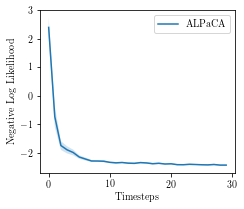

In [21]:
plt.figure(figsize=(3.5,3))
nll_plot(alpaca_nll_mean,alpaca_nll_var, None, None, None, None,N_test,legend=True)
# nll_plot(alpaca_nll_mean,alpaca_nll_var,lpaca_nll_mean,lpaca_nll_var,gp_nll_mean,gp_nll_var,N_test,legend=True)
plt.savefig('figures/nll_rockerbogie.pdf')
plt.show()

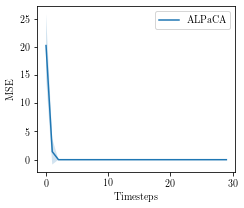

In [22]:
plt.figure(figsize=(3.5,3))
mse_plot(alpaca_mse_mean,alpaca_mse_var,None,None,None,None,N_test,legend=True)
plt.tight_layout()
plt.savefig('figures/mse_rockerbogie.pdf')
plt.show()